# Experiment in trying to predict a lottey number

Note: We know that is almost impossible BUT we can try to apply some Data Sciencey stuff and see what will happen

So... the plan is to use a quick model first like ARIMA and see the results and after that we will build a full scalle deep learning model!

In [2]:
# imports
import pandas as pd
import numpy as np
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from src.utils import read_all_parquet_files
from src.model import Model
from src.trainer import Trainer

In [3]:
# dataset filename
DATASET_LOCAL_COPY = './static/data/'

# List of columns to forecast
COLUMNS_TO_FORECAST = ['Ball_1', 'Ball_2', 'Ball_3', 'Ball_4', 'Ball_5', 'Ball_Bonus']

# Location of stored models
MODEL_LOCATION = './static/model/'

In [4]:
# read in lottery games data 
all_games = read_all_parquet_files(DATASET_LOCAL_COPY)

# need to convert data 
all_games['Ball_1'] = all_games['Ball_1'].astype('float64')
all_games['Ball_2'] = all_games['Ball_2'].astype('float64')
all_games['Ball_3'] = all_games['Ball_3'].astype('float64')
all_games['Ball_4'] = all_games['Ball_4'].astype('float64')
all_games['Ball_5'] = all_games['Ball_5'].astype('float64')
all_games['Ball_Bonus'] = all_games['Ball_Bonus'].astype('float64')

min_date = all_games['Date'].min()
max_date = all_games['Date'].max()

# sort by date
all_games.sort_values(by=['Date'], ascending=False, inplace=True)
# set index
all_games.set_index('Date', inplace=True)
# specify frequency IMPORTANT
all_games.index = pd.DatetimeIndex(all_games.index).to_period('3.5D')

## Randomize 

I do not think that we care if the data is ordered or not so let just get it randomized

we can also use 
```
from sklearn.utils import shuffle
all_games = shuffle(all_games)
```

In [5]:
all_games = all_games.sample(frac=1).reset_index(drop=True)

<Axes: >

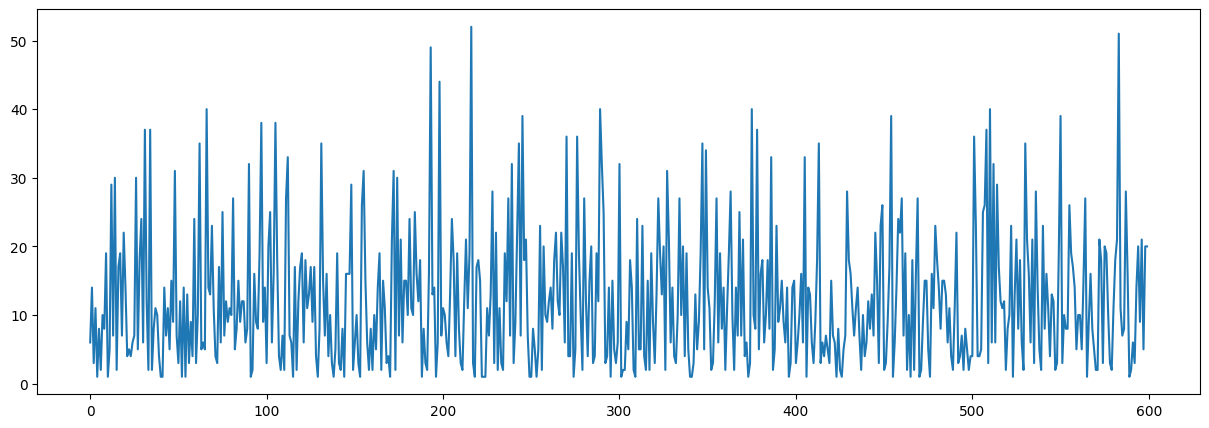

In [6]:
# let us take a look at one of the columns
endog = all_games['Ball_1']
endog.plot(figsize=(15, 5))

In [7]:
all_games.describe(include='all')

,Ball_1,Ball_2,Ball_3,Ball_4,Ball_5,Ball_Bonus
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,12.143333,23.256667,35.250000,47.155000,58.543333,13.296667
std,9.800998,11.853761,12.437926,11.977064,9.383222,7.713699
min,1.000000,2.000000,3.000000,7.000000,22.000000,1.000000
25%,4.000000,14.750000,26.000000,39.000000,54.000000,6.000000
50%,10.000000,22.000000,36.000000,48.000000,61.000000,13.000000
75%,18.000000,31.000000,44.000000,57.000000,66.000000,20.000000
max,52.000000,58.000000,64.000000,68.000000,69.000000,26.000000


## let us add additional features

In [8]:
# Calculate weights based on historical frequency
weights = {}
for column in COLUMNS_TO_FORECAST:
    number_counts = all_games[column].value_counts(normalize=True).to_dict()
    total_samples = len(all_games[column])
    column_weights = {number: count / total_samples for number, count in number_counts.items()}
    weights[column] = column_weights
    #all_games[f'{column}_weight'] = column_weights

In [9]:
t = weights.get('Ball_1')
t.get(3)

0.00010833333333333334

In [10]:
# use first rows for training and use last row for out-of-sample testing
X_train_all_balls, X_test_all_balls = all_games.iloc[:-1, :len(COLUMNS_TO_FORECAST)], all_games.iloc[[-1], :len(COLUMNS_TO_FORECAST)]

In [11]:
X_train_all_balls.describe()

,Ball_1,Ball_2,Ball_3,Ball_4,Ball_5,Ball_Bonus
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,12.130217,23.255426,35.245409,47.140234,58.527546,13.288815
std,9.803917,11.863629,12.447812,11.981607,9.383086,7.717746
min,1.000000,2.000000,3.000000,7.000000,22.000000,1.000000
25%,4.000000,14.500000,26.000000,39.000000,54.000000,6.000000
50%,10.000000,22.000000,36.000000,48.000000,61.000000,13.000000
75%,18.000000,31.000000,44.000000,57.000000,66.000000,20.000000
max,52.000000,58.000000,64.000000,68.000000,69.000000,26.000000


In [12]:
X_test_all_balls

,Ball_1,Ball_2,Ball_3,Ball_4,Ball_5,Ball_Bonus
599,20.0,24.0,38.0,56.0,68.0,18.0


# Let us try to optimize our ARIMA model

The expected value range for the hyperparameters p, d, and q in an ARIMA model depends on the characteristics of your time series data. These hyperparameters determine the autoregressive (AR), differencing (I), and moving average (MA) components of the model, respectively. Here are some general guidelines for choosing values within these ranges:

p (AR order):

The autoregressive order (p) represents the number of lagged observations included in the model. It indicates how many past time points are used to predict the current value.
A typical range for p is 0 to 3. If the autocorrelation plot (ACF) shows significant values at lags 1, 2, or 3, you may consider these values for p.
Use the PACF plot to help determine the initial estimate for p.
d (I order):

The differencing order (d) indicates the number of times the time series needs to be differenced to achieve stationarity. It removes trends and seasonality from the data.
A common range for d is 0 to 2. If your data is already stationary, use d=0. If first-order differencing is required to make the data stationary, use d=1. In some cases, second-order differencing (d=2) may be necessary.
q (MA order):

The moving average order (q) represents the number of lagged forecast errors (residuals) included in the model. It captures the dependency on past forecast errors.
A typical range for q is 0 to 3. If the autocorrelation of the residuals (ACF of residuals) shows significant values at lags 1, 2, or 3, you may consider these values for q.
The ACF of residuals is used to determine the initial estimate for q.
These ranges are general guidelines and can vary depending on the specific characteristics of your time series. It's often a good practice to start with smaller values and incrementally increase them while monitoring the model's performance (e.g., using cross-validation or evaluation metrics) to avoid overfitting.

Keep in mind that the optimal values for p, d, and q may require experimentation, and automated tools like grid search or the auto_arima function in libraries such as pmdarima can help identify the best hyperparameters based on the data.

In [13]:
# instantiate model trainer 
trainer = Trainer()

models_for_each_ball = {}

# Perform a grid search to find the best ARIMA model
for column in COLUMNS_TO_FORECAST:
    ts_data = X_train_all_balls[column]

    try:
        # Use auto_arima to automatically select the best hyperparameters
        best_order, best_model = trainer.find_best_arima_model(ts_data=ts_data)

        # Fit the ARIMA model with the best hyperparameters
        arima_model, arima_model_fit = trainer.fit_arima_model(
            ts_data=ts_data,
            order=best_order
        )

        # Create an instance of the Model class
        my_model = Model(name=column,
                         model=arima_model,
                         model_fit=arima_model_fit,
                         order=best_order)
        
        # save model and model's summary for each ball
        arima_model_fit.save(f'{MODEL_LOCATION}{column}_model.pkl')
        with open(f'{MODEL_LOCATION}{column}_model_metadata.txt', 'w',encoding='UTF-8') as f:
            summary = arima_model_fit.summary().as_text()
            f.write(summary)

        models_for_each_ball[column] = my_model
    except Exception as e:
        print (f'Exception -> {e}')
        continue

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4992.475, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4738.261, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4853.292, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4647.295, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4600.863, Time=0.06 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=4578.220, Time=0.09 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=4562.853, Time=0.17 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.91 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.96 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=4444.180, Time=0.24 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=4443.223, Time=0.15 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=4442.260, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4440.483, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4438.8

In [14]:
# List of trained ARIMA models
arima_models = []

# Loop through each column and fit ARIMA models
for column in COLUMNS_TO_FORECAST:
    ts_data = all_games[column]
    # get the best model from the previous step
    model = models_for_each_ball[column]
    arima_models.append(model)

    final_model = model.model
    final_model_fit = model.model_fit

    # Forecast the next data point
    #forecast = final_model_fit.predict(n_periods=len(ts_data),steps=1)
    # make one-day forecast
    forecast = final_model_fit.predict(n_periods=1, exog=None, return_conf_int=True)

    print(f"Forecast for ('{column}'): {forecast.iloc[0]:.2f}")

Forecast for ('Ball_1'): 12.13
Forecast for ('Ball_2'): 23.26
Forecast for ('Ball_3'): 35.25
Forecast for ('Ball_4'): 47.14
Forecast for ('Ball_5'): 58.53
Forecast for ('Ball_Bonus'): 13.29


In [17]:
results = []
# Loop through each column and fit ARIMA models
for column in COLUMNS_TO_FORECAST:
    ts_data = all_games[column].astype(float)
    # Generate predictions from each ARIMA model
    result = 0
    for model in arima_models:
        final_model = model.model
        model_fit = model.model_fit

        # Forecast the next data point
        forecast = model_fit.predict(n_periods=1)
        #print(forecast[0])
        #print(forecast[-1])
        #forecast = final_model_fit.forecast()

        result += forecast[0]
    
    results.append(f'{column} -> {int(result/len(arima_models))} weight ({weights.get(column).get(int(result/len(arima_models)))})')

In [18]:
for x in results:
    print (x)

Ball_1 -> 31 weight (1.1111111111111112e-05)
Ball_2 -> 31 weight (4.166666666666667e-05)
Ball_3 -> 31 weight (4.166666666666667e-05)
Ball_4 -> 31 weight (1.6666666666666667e-05)
Ball_5 -> 31 weight (None)
Ball_Bonus -> 31 weight (None)


# let us look inside the models 

The summary method produces several convenient tables showing the results.

In [20]:
for model in arima_models:
    final_model = model.model_fit
    print(final_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 Ball_1   No. Observations:                  599
Model:                          ARIMA   Log Likelihood               -2216.830
Date:                Tue, 19 Sep 2023   AIC                           4437.660
Time:                        14:36:52   BIC                           4446.451
Sample:                             0   HQIC                          4441.083
                                - 599                                         
Covariance Type:        robust_approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.1302      0.400     30.307      0.000      11.346      12.915
sigma2        95.9563      6.906     13.894      0.000      82.420     109.493
Ljung-Box (L1) (Q):                   0.83   Jarque-